# Solución 1

## Detección de intrusos en redes

Estos datos fueron usados para la edición de 1999 del KDD cup. Los datos fueron generados por Lincoln Labs: _Nueve semanas de registro de paquetes TCP fueron recolectadas para una red LAN de una oficina de las fuerzas aéreas de USA._ Durante el uso de la LAN, _varios ataques_ fueron ejecutados por el personal. El paquete crudo fue agregado junto con la información de la conexión. 

Para cada registro, algunas características extra fueron derivadas, basados en conocimiento del dominio sobre ataques a redes; _hay 38 tipos diferentes de ataques, pertenecientes a 4 categorías principales_. Algunos tipos de ataque aparecen solo en los datos de prueba(test data), y las frecuencias de los tipo de ataque en los conjuntos de entrenamiento y prueba no son las mismas(para hacerlo más realista). Información adicional sobre los datos puede ser encontrada en (http://kdd.ics.uci.edu/databases/kddcup99/task.html) y los resumenes de los resultados de la competencia KDD cup (http://cseweb.ucsd.edu/~elkan/clresults.html). En la última página también se indica que hay una matriz de costo asociada con las equivocaciones.  El ganador de la competencia usó árboles de decisión C5 en combinación con boosting y bagging.

**Referencias**:
- PNrule: _A New Framework for Learning Classifier Models in Data Mining (A Case-Study in Network Intrusion Detection) (2000) by R. Agarwal and M. V. Joshi_. This paper proposes a new, very simple rule learning algorithm, and tests it on the network intrusion dataset. In the first stage, rules are learned to identify the target class, and then in the second stage, rules are learned to identify cases that were incorrectly classified as positive according to the first rules.

## Pasos a llevar a cabo en la solución 1

- Cargar las librerías a utilizar
- Cargar los datos e importarlos a un dataframe
- Visualizar los datos
- Limpiar y transformar los datos
- Códificar los datos
- Seleccionar los parámetros más importantes
- Separando el conjunto de datos de entrenamiento y de validación
- Selección de algoritmos y métodos
- Validación Cruzada con KFold
- Resumen de los métodos utilizados
- Comparación de resultados con el ganador del KDDCup

## Cargar las librerías a utilizar

In [1]:
%matplotlib inline

from time import time
from itertools import product
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from IPython.display import display, HTML

# Modulo personal para hacer mas claro el ejercicio
from egironML import EDA
from egironML import run_kfold

plt.style.use('seaborn-white')

## Cargar los datos e importarlos a un dataframe

In [2]:
# Cargamos los datos de Detección de intrusos por medio de un modelo personalizado
ataques_10perc, ataques_correg_test_10perc = EDA.load_attack_rawData()

Cantidad de observaciones (Entrenamiento):  494021
Cantidad de observaciones (Validación):  311029
Cantidad de ataques (Entrenamiento):  23
Cantidad de ataques (Validación):  38


## Visualizar los datos

In [3]:
ataques_10perc.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_types
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
EDA.printall(ataques_correg_test_10perc, 15)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_types
0,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
3,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
5,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
6,0,udp,domain_u,SF,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0.0,0.0,0.0,0.0,0.5,1.0,0.0,10,3,0.3,0.30,0.30,0.0,0.0,0.0,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311022,0,udp,private,SF,105,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,normal.
311023,0,udp,private,SF,105,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.


In [5]:
# ataques_correg_test_10perc.sample(3)

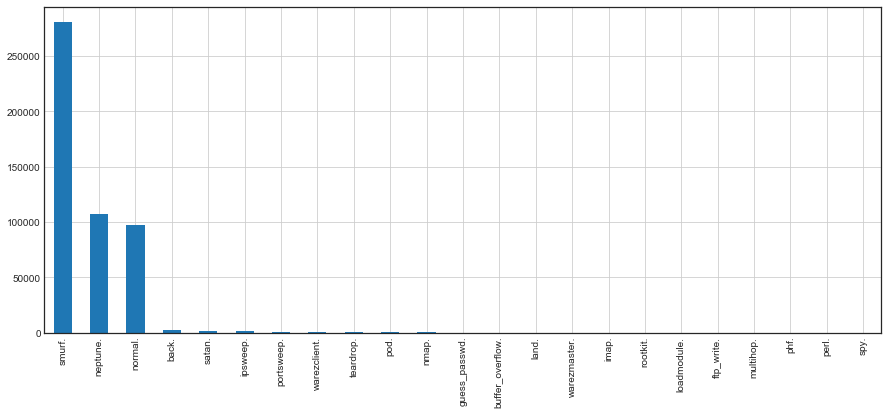

In [6]:
# Veamos la distribucción de los ataques
ataques_10perc.attack_types.value_counts().plot(kind='bar', grid=True, figsize=(15, 6))

In [7]:
ataques_10perc.attack_types.value_counts()

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: attack_types, dtype: int64

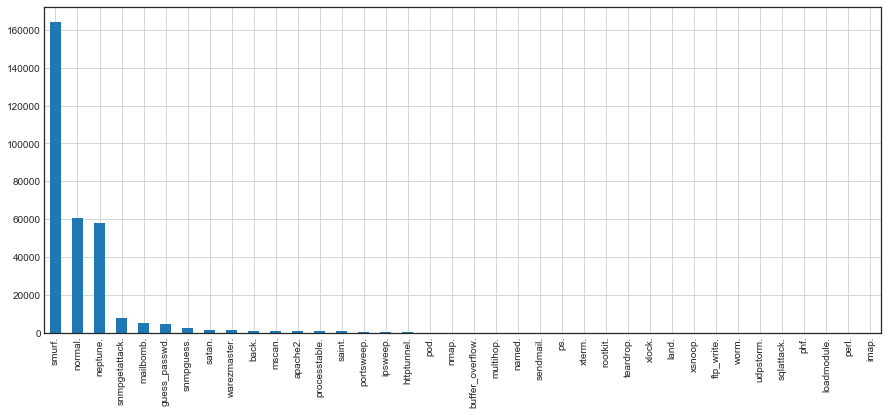

In [8]:
ataques_correg_test_10perc.attack_types.value_counts().plot(kind='bar', grid=True, figsize=(15, 6))

In [9]:
ataques_correg_test_10perc.attack_types.value_counts()

smurf.              164091
normal.              60593
neptune.             58001
snmpgetattack.        7741
mailbomb.             5000
guess_passwd.         4367
snmpguess.            2406
satan.                1633
warezmaster.          1602
back.                 1098
mscan.                1053
apache2.               794
processtable.          759
saint.                 736
portsweep.             354
ipsweep.               306
httptunnel.            158
pod.                    87
nmap.                   84
buffer_overflow.        22
multihop.               18
named.                  17
sendmail.               17
ps.                     16
xterm.                  13
rootkit.                13
teardrop.               12
xlock.                   9
land.                    9
xsnoop.                  4
ftp_write.               3
worm.                    2
udpstorm.                2
sqlattack.               2
phf.                     2
loadmodule.              2
perl.                    2
i

In [10]:
print("Cantidad de ataques (Entrenamiento): ",len(ataques_10perc.attack_types.unique()))
print("Cantidad de ataques (Validación): ",len(ataques_correg_test_10perc.attack_types.unique()))

Cantidad de ataques (Entrenamiento):  23
Cantidad de ataques (Validación):  38


## Limpiar y transformar los datos

Como se aprecia en los datos anteriores, la cantidad de ataques son diferentes en en el conjunto de datos de entrenamiento y valdación. Igualmente poseen un punto al final de cada atributo de tipo de ataque. Por ultimo hay algunas variables o predictores de tipo categórico.

In [11]:
# Reemplazamos el . en los vlores del precitor de tipos de ataques.
EDA.replace_column_string(ataques_10perc, 'attack_types', '.', '')
EDA.replace_column_string(ataques_correg_test_10perc, 'attack_types', '.', '')

In [12]:
ataques_10perc.attack_types.unique()

array(['normal', 'buffer_overflow', 'loadmodule', 'perl', 'neptune',
       'smurf', 'guess_passwd', 'pod', 'teardrop', 'portsweep', 'ipsweep',
       'land', 'ftp_write', 'back', 'imap', 'satan', 'phf', 'nmap',
       'multihop', 'warezmaster', 'warezclient', 'spy', 'rootkit'], dtype=object)

In [13]:
ataques_correg_test_10perc.attack_types.unique()

array(['normal', 'snmpgetattack', 'named', 'xlock', 'smurf', 'ipsweep',
       'multihop', 'xsnoop', 'sendmail', 'guess_passwd', 'saint',
       'buffer_overflow', 'portsweep', 'pod', 'apache2', 'phf', 'udpstorm',
       'warezmaster', 'perl', 'satan', 'xterm', 'mscan', 'processtable',
       'ps', 'nmap', 'rootkit', 'neptune', 'loadmodule', 'imap', 'back',
       'httptunnel', 'worm', 'mailbomb', 'ftp_write', 'teardrop', 'land',
       'sqlattack', 'snmpguess'], dtype=object)

In [14]:
# Verificamos el tipo de dato en cada atributo o predictor
ataques_10perc.info()
ataques_correg_test_10perc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
duration                       494021 non-null int64
protocol_type                  494021 non-null object
service                        494021 non-null object
flag                           494021 non-null object
src_bytes                      494021 non-null int64
dst_bytes                      494021 non-null int64
land                           494021 non-null int64
wrong_fragment                 494021 non-null int64
urgent                         494021 non-null int64
hot                            494021 non-null int64
num_failed_logins              494021 non-null int64
logged_in                      494021 non-null int64
num_compromised                494021 non-null int64
root_shell                     494021 non-null int64
su_attempted                   494021 non-null int64
num_root                       494021 non-null int64
num_file_creations             494021 

Como se puede apreciar el conjunto de entrenamiento tiene **494021** observaciones y el de validación **311029**; todas las vairables estan completas por lo que no hay valores faltantes o nulos. De igual forma se notan 4 variables categóricas (*protocol_type, service, flag y attack_types*). 

In [15]:
# Varificamos de nuevo o de otra forma si hay datos faltantes o nulos
# ataques_10perc.isnull().sum()
EDA.hasNull(ataques_10perc)

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [16]:
ataques_10perc.isin([np.nan, np.inf, -np.inf]).any(1).sum()

0

In [76]:
#ataques_correg_test_10perc.apply(EDA.hasNull)

In [19]:
ataques_correg_test_10percAll = ataques_correg_test_10perc.copy() # Salvamos una copia con todos los datos para validar

In [20]:
len(ataques_correg_test_10percAll)

311029

In [21]:
# Eliminar duplicados
EDA.delduplicates(ataques_10perc)
EDA.delduplicates(ataques_correg_test_10perc)

Eliminó 145586 observaciones de un total de 494021
Eliminó 77291 observaciones de un total de 311029


Es necesario tener en cuenta que los resultados que se muestran en las matríz de confusión del ganador del KDD Cup son con todos los 311029 datos incluyendo los duplicados.

In [22]:
# Ahora transformamos algunos datos como lo son los tipo de ataques
# Agrupamos los tipos de ataques en las 4 categorías recomendadas
EDA.create_category_attack(ataques_10perc)
EDA.create_category_attack(ataques_correg_test_10perc)
EDA.create_category_attack(ataques_correg_test_10percAll)

Categorías encontradas: ['normal' 'u2r' 'dos' 'r2l' 'probe']
Categorías encontradas: ['normal' 'unknown' 'dos' 'probe' 'r2l' 'u2r']
Categorías encontradas: ['normal' 'unknown' 'dos' 'probe' 'r2l' 'u2r']


In [23]:
# Ahora creamos una variable binaria (0/1 o No/Yes o good/bad) para guardar las conexiones con o sin ataques
# Esto nos permite aplicar modelos de regresión mas adelante
EDA.create_category_binAttack(ataques_10perc)
EDA.create_category_binAttack(ataques_correg_test_10perc)
EDA.create_category_binAttack(ataques_correg_test_10percAll)

Categorías encontradas: [0 1]
Categorías encontradas: [0 1]
Categorías encontradas: [0 1]


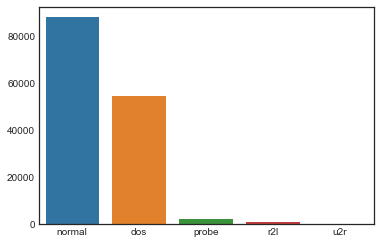

In [24]:
gdata = ataques_10perc.attack_category.value_counts()
sns.barplot(x=gdata.keys().tolist(), y=gdata.data.tolist())

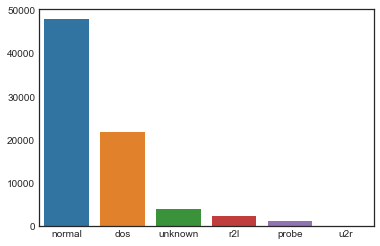

In [25]:
gdata = ataques_correg_test_10perc.attack_category.value_counts()
sns.barplot(x=gdata.keys().tolist(), y=gdata.data.tolist())

In [26]:
import plotly
from plotly.graph_objs import Bar, Scatter, Layout, Figure
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)

gdata = ataques_correg_test_10perc.attack_types.value_counts()
attackctg = Bar(x=gdata.keys().tolist(), y=gdata.data.tolist(), name='Attack', marker=dict(color='#ff1123') )

data = [attackctg]
layout = Layout(title="Frecuencia de Tipos de Ataques", xaxis=dict(title='Tipos de Ataques'), 
                yaxis=dict(title='Cantidad de Ataques (en miles)'))
fig = Figure(data=data, layout=layout)

iplot(fig)

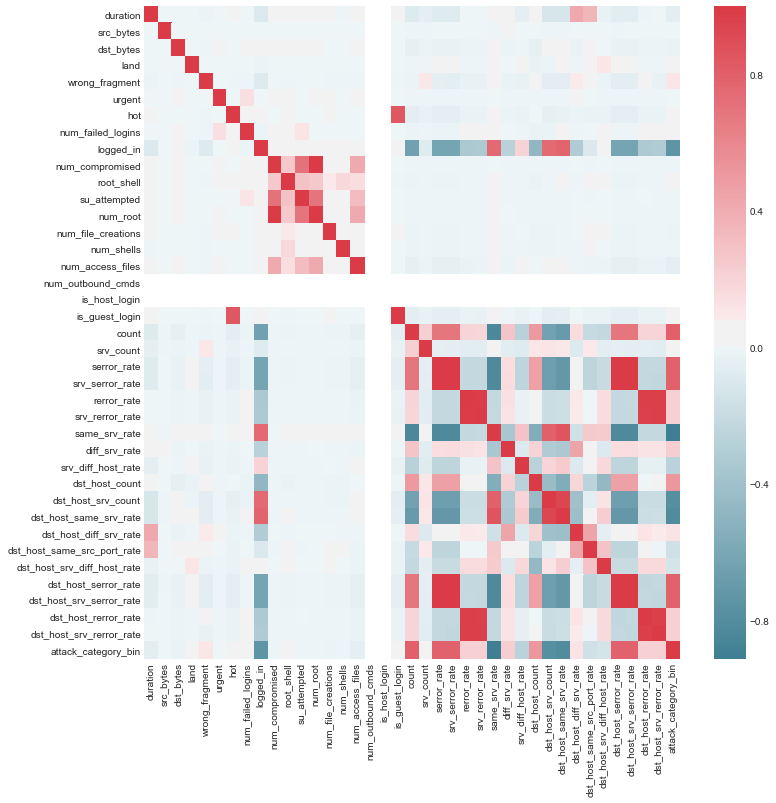

In [27]:
corr = ataques_10perc.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=False, ax=ax)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1eb96ef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a22ca0550>]], dtype=object)

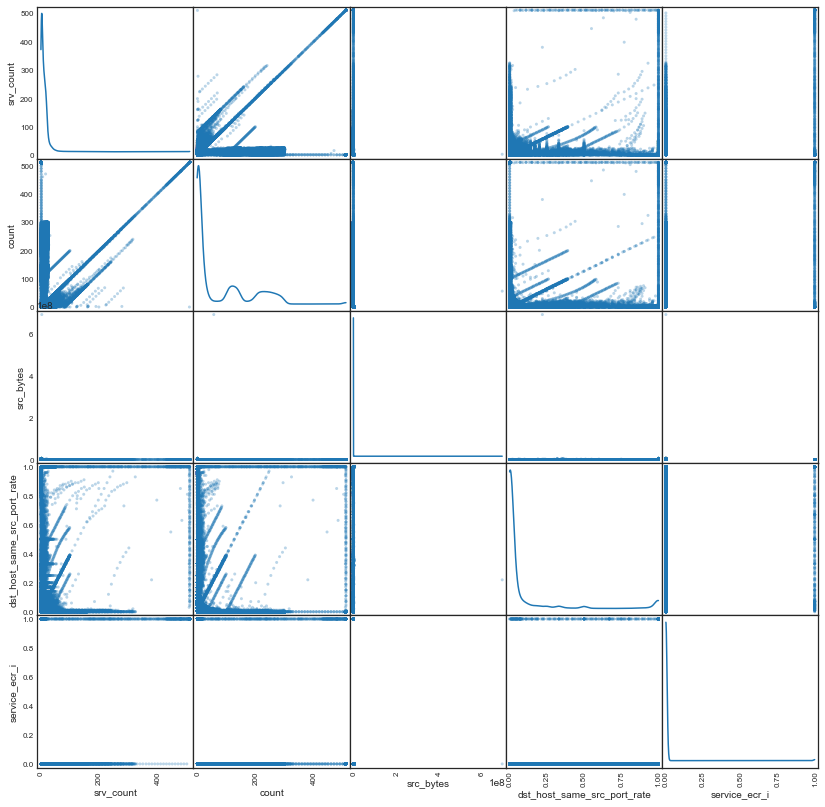

In [77]:
# Esto estaba comentado por que toma mucho tiempo y se bloquea o no produce ningún resultado cuando se utilizan
# todos los datos de entrenamiento y todas las variables
# Para mostrar como funciona lo hacemos con los 5 predictores mas importantes
datatograph = ataques_10perc[['srv_count', 'count', 'src_bytes', 'dst_host_same_src_port_rate', 'service_ecr_i']]
pd.plotting.scatter_matrix(datatograph, alpha = 0.3, figsize = (14,14), diagonal = 'kde')

## Códificar los datos

Como se observó en las tablas anteriores, existen 4 variables categóricas entre los 42 predictores disponibles.

Para poder trabajar con los algoritmos, la mayoría por no decir todos deben tener los datos en formato númerico, de esta forma es más facil hacer la computación de lo que se busca. 

Dicho lo anterior, creamos variables dummies para los atributos categóricos

In [29]:
# identificamos los posibles valores de cada predictor categórico
ataques_10perc.protocol_type.unique() # type of the protocol
#ataques_correg_test_10perc.protocol_type.unique()

array(['tcp', 'udp', 'icmp'], dtype=object)

In [30]:
ataques_10perc.service.unique() # network service on the destination

array(['http', 'smtp', 'finger', 'domain_u', 'auth', 'telnet', 'ftp',
       'eco_i', 'ntp_u', 'ecr_i', 'other', 'private', 'pop_3', 'ftp_data',
       'rje', 'time', 'mtp', 'link', 'remote_job', 'gopher', 'ssh', 'name',
       'whois', 'domain', 'login', 'imap4', 'daytime', 'ctf', 'nntp',
       'shell', 'IRC', 'nnsp', 'http_443', 'exec', 'printer', 'efs',
       'courier', 'uucp', 'klogin', 'kshell', 'echo', 'discard', 'systat',
       'supdup', 'iso_tsap', 'hostnames', 'csnet_ns', 'pop_2', 'sunrpc',
       'uucp_path', 'netbios_ns', 'netbios_ssn', 'netbios_dgm', 'sql_net',
       'vmnet', 'bgp', 'Z39_50', 'ldap', 'netstat', 'urh_i', 'X11',
       'urp_i', 'pm_dump', 'tftp_u', 'tim_i', 'red_i'], dtype=object)

In [31]:
len(ataques_correg_test_10perc.service.unique())

65

In [32]:
ataques_10perc.flag.unique()
# ataques_correg_test_10perc.flag.unique()

array(['SF', 'S1', 'REJ', 'S2', 'S0', 'S3', 'RSTO', 'RSTR', 'RSTOS0',
       'OTH', 'SH'], dtype=object)

In [33]:
EDA.describe_categorical(ataques_10perc)

,protocol_type,service,flag,attack_types,attack_category
count,145586,145586,145586,145586,145586
unique,3,66,11,23,5
top,tcp,http,SF,normal,normal
freq,130913,62054,87459,87832,87832


In [34]:
EDA.describe_categorical(ataques_correg_test_10percAll)

,protocol_type,service,flag,attack_types,attack_category
count,311029,311029,311029,311029,311029
unique,3,65,11,38,6
top,icmp,ecr_i,SF,smurf,dos
freq,164969,164352,248379,164091,223298


In [35]:
EDA.describe_categorical(ataques_correg_test_10perc)

,protocol_type,service,flag,attack_types,attack_category
count,77291,77291,77291,77291,77291
unique,3,65,11,38,6
top,tcp,http,SF,normal,normal
freq,71124,40350,53624,47913,47913


In [36]:
EDA.display_info_numericas(ataques_10perc)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_category_bin
count,145586.000000,1.455860e+05,1.455860e+05,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.0,145586.0,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000
mean,132.025181,7.995700e+03,2.859780e+03,0.000137,0.020201,0.000048,0.100174,0.000515,0.491490,0.026177,0.000378,0.000124,0.038520,0.003675,0.000371,0.003414,0.0,0.0,0.004705,74.385593,13.011464,0.291379,0.291551,0.108355,0.108412,0.655194,0.040576,0.093079,181.468177,129.934678,0.553222,0.061389,0.092825,0.019048,0.291597,0.290978,0.110463,0.107675,0.396700
std,1224.157053,1.820383e+06,6.080979e+04,0.011720,0.239368,0.010150,1.426798,0.028585,0.499929,3.311373,0.019433,0.014354,3.707494,0.177581,0.020298,0.067091,0.0,0.0,0.068433,100.335945,30.736126,0.452903,0.453567,0.308961,0.308805,0.446795,0.120396,0.241952,99.098197,114.714829,0.456236,0.147021,0.241123,0.060410,0.452492,0.453447,0.306097,0.304220,0.489214
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,78.000000,12.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.470000e+02,1.050000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,117.000000,0.770000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.880000e+02,1.164750e+03,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,132.000000,15.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.030000,0.020000,1.000000,1.000000,0.000000,0.000000,1.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,1.000000,2.000000,993.000000,28.000000,2.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
EDA.display_info_numericas(ataques_correg_test_10perc)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_category_bin
count,77291.000000,7.729100e+04,7.729100e+04,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.0,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000
mean,70.761512,3.427815e+03,2.870840e+03,0.000116,0.002536,0.000207,0.040108,0.006560,0.584984,0.036071,0.000802,0.000091,0.033639,0.003856,0.000336,0.003092,0.0,0.000155,0.009522,68.089545,18.335938,0.097226,0.097700,0.209443,0.208505,0.729535,0.046626,0.097434,178.379967,158.263265,0.660726,0.046290,0.076670,0.015713,0.095485,0.096153,0.208265,0.205849,0.380096
std,815.287350,2.554528e+05,3.222983e+04,0.010790,0.077607,0.019700,0.594381,0.084178,0.492728,3.927196,0.028311,0.011929,4.343357,0.387388,0.025936,0.058914,0.0,0.012459,0.097118,105.097338,53.463996,0.290319,0.293166,0.401511,0.402583,0.423010,0.161054,0.230076,99.731377,112.549257,0.437582,0.134296,0.221153,0.052576,0.282351,0.287721,0.391682,0.397386,0.485413
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000,71.000000,16.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.110000e+02,3.210000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,10.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,250.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.960000e+02,1.774000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,119.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.060000,0.080000,255.000000,255.000000,1.000000,0.060000,0.020000,0.020000,0.000000,0.000000,0.040000,0.000000,1.000000
max,57715.000000,6.282565e+07,5.203179e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,1.000000,2.000000,878.000000,100.000000,5.000000,4.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
# Antes de crear las variables dummy, crearemos un dataframe con los dos conjuntos de datos, tanto de entrenamiento
# como de validación; esto con el fin de utilizarlo mas adelante en la selección de los mejores predictores 
# y otros procesos

# X = ataques_10perc.copy()
# X.append(ataques_correg_test_10perc.copy(), ignore_index=True)

X = pd.concat([ataques_10perc, ataques_correg_test_10perc], axis=0, copy=True) # Unimos las observaciones de ambos conjuntos
X.shape

(222877, 44)

In [40]:
# Como todas las variables tienen más de 2 valores en sus atributos, podemos usar la función get_dummies de pandas
# De lo contrario solo debemos utilizar "factorize", para crear variables nominales binarias a numericas
# De igual modo para variables categóricas con más de 2 valores pero "ordinales"
categorical_variables = ['protocol_type', 'service', 'flag']
ataques_10perc = EDA.create_dummies(ataques_10perc, categorical_variables)
ataques_correg_test_10perc = EDA.create_dummies(ataques_correg_test_10perc, categorical_variables)
ataques_correg_test_10percAll = EDA.create_dummies(ataques_correg_test_10percAll, categorical_variables)
X = EDA.create_dummies(X, categorical_variables)

In [41]:
ataques_10perc.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,145586.000000,1.455860e+05,1.455860e+05,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,...,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000
mean,132.025181,7.995700e+03,2.859780e+03,0.000137,0.020201,0.000048,0.100174,0.000515,0.491490,0.026177,...,0.101054,0.003908,0.000076,0.002919,0.290399,0.000392,0.000165,0.000069,0.600738,0.000234
std,1224.157053,1.820383e+06,6.080979e+04,0.011720,0.239368,0.010150,1.426798,0.028585,0.499929,3.311373,...,0.301401,0.062395,0.008692,0.053951,0.453948,0.019783,0.012838,0.008288,0.489748,0.015280
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.470000e+02,1.050000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,2.880000e+02,1.164750e+03,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
ataques_correg_test_10perc.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,77291.000000,7.729100e+04,7.729100e+04,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,...,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000,77291.000000
mean,70.761512,3.427815e+03,2.870840e+03,0.000116,0.002536,0.000207,0.040108,0.006560,0.584984,0.036071,...,0.180978,0.017855,0.000026,0.009290,0.092792,0.000349,0.000285,0.003545,0.693794,0.001035
std,815.287350,2.554528e+05,3.222983e+04,0.010790,0.077607,0.019700,0.594381,0.084178,0.492728,3.927196,...,0.385003,0.132424,0.005087,0.095934,0.290143,0.018687,0.016869,0.059435,0.460920,0.032156
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.110000e+02,3.210000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,2.960000e+02,1.774000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,57715.000000,6.282565e+07,5.203179e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Seleccionar los parámetros más importantes

Para la selección de los mejores atributos o predictores exiten varias técnicas, aquí solo aplicamos 2 que son eficientes computacionalmente. En el [notebook o notas pasadas](Deteccion%20intrusos%20redes.ipynb#Selecci%C3%B3n-de-los-mejores-atributos-o-predictores) se llevaron a cabo algunos otros metodos.

Los resultados fueron distintos en todos los casos, lo que no es algo en lo que se pueda confiar y menos desconociendo la teoría o lógica del problema de redes de comunicación digital.

In [43]:
# Una forma rápida es gráficar o visualizar la matríz de correlaciones entre predictores
corr = ataques_10perc.corr()
corr.head(40)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
duration,1.000000,0.004280,0.002582,-0.001264,-0.009102,0.003707,0.009855,0.004343,-0.090667,0.061454,...,-0.036160,-0.001936,0.022591,0.229275,-0.068994,-0.002134,-0.001367,0.002616,0.060932,-0.001648
src_bytes,0.004280,1.000000,-0.000162,-0.000051,-0.000365,-0.000018,0.003999,-0.000077,-0.000928,0.000025,...,-0.001473,0.041658,-0.000038,0.000225,-0.002810,0.000062,0.000029,0.002302,-0.001860,-0.000067
dst_bytes,0.002582,-0.000162,1.000000,-0.000551,-0.003969,0.016147,0.000658,0.048789,0.028106,0.022755,...,-0.015768,-0.002490,-0.000409,-0.000773,-0.030085,0.007543,0.006105,0.000203,0.037558,-0.000719
land,-0.001264,-0.000051,-0.000551,1.000000,-0.000989,-0.000056,-0.000823,-0.000211,-0.011524,-0.000093,...,-0.003930,-0.000734,-0.000102,-0.000634,0.018323,-0.000232,-0.000151,-0.000097,-0.014378,-0.000179
wrong_fragment,-0.009102,-0.000365,-0.003969,-0.000989,1.000000,-0.000400,-0.005925,-0.001521,-0.082969,-0.000667,...,-0.028296,-0.005286,-0.000734,-0.004566,-0.053988,-0.001670,-0.001084,-0.000699,0.068801,-0.001290
urgent,0.003707,-0.000018,0.016147,-0.000056,-0.000400,1.000000,0.000142,0.141954,0.004818,0.014268,...,-0.001588,-0.000297,-0.000041,-0.000256,-0.003030,-0.000094,-0.000061,-0.000039,0.003862,-0.000072
hot,0.009855,0.003999,0.000658,-0.000823,-0.005925,0.000142,1.000000,0.007997,0.070770,0.003533,...,-0.023540,-0.000231,-0.000610,0.007890,-0.044904,-0.000416,0.005848,0.003484,0.055124,-0.001073
num_failed_logins,0.004343,-0.000077,0.048789,-0.000211,-0.001521,0.141954,0.007997,1.000000,-0.013872,0.006824,...,-0.006042,0.172173,-0.000157,0.016840,-0.011529,-0.000357,-0.000231,0.057839,-0.010331,-0.000275
logged_in,-0.090667,-0.000928,0.028106,-0.011524,-0.082969,0.004818,0.070770,-0.013872,1.000000,0.008041,...,-0.329622,-0.051232,-0.008546,-0.024418,-0.628923,0.016658,0.011991,0.003457,0.794693,-0.015026
num_compromised,0.061454,0.000025,0.022755,-0.000093,-0.000667,0.014268,0.003533,0.006824,0.008041,1.000000,...,-0.002650,-0.000495,-0.000069,0.001072,-0.005057,-0.000156,0.000060,-0.000066,0.006275,-0.000121


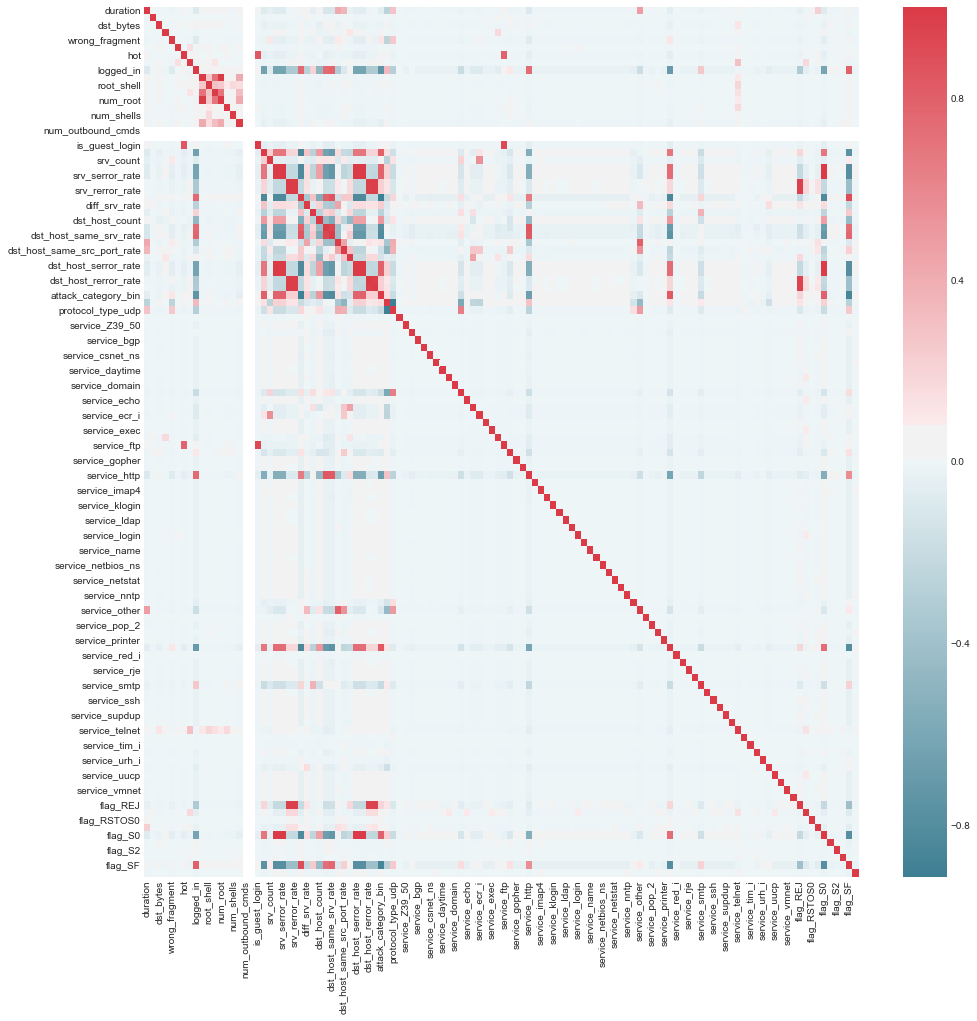

In [44]:
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=False, ax=ax)

### Aplicamos métodos automáticos para la selección de las variables

In [46]:
# Eliminamos los datos infinitos, nulos o errados para evitar errores en los algortimos de ML
# X = EDA.clean_dataset(X)

In [47]:
# Teniendo en cuenta que los datos contienen las variables independientes o a predicir
# Procedemos a removerlas (attack_types, attack_category, attack_category_bin)
y_all = X.attack_types.copy() # las 24 o 38 tipos de ataques
y_4f = X.attack_category.copy() # Solo 4 categorias
y_bin = X.attack_category_bin.copy() # Solo 2 categorias binarias

X.drop(['attack_types', 'attack_category', 'attack_category_bin'], axis=1, inplace=True)

In [48]:
X.shape

(222877, 116)

In [49]:
y_all.shape

(222877,)

In [50]:
# Seperamos los datos en entrenamiento 70% y validación 30%
# X = scale(X) # Normalizar o escalar los datos
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=1)

In [51]:
# Selección Univariada - Univariate Selection
t0 = time()
# feature extraction
test = SelectKBest(score_func=chi2, k=10)
fit = test.fit(X_train, y_train)
# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X_train)
# summarize selected features
print(features[0:11,:])
print("Numero de variables seleccionadas:", features.shape[1])
print("Tiempo total: %.2fs" % (time() - t0))

[  4.719e+05   1.372e+09   9.957e+07   3.112e+01   3.088e+03   2.179e+01
   4.444e+03   5.184e+02   4.214e+04   2.908e+02   1.738e+01   6.523e+00
   2.337e+03   9.588e+01   3.279e+00   2.463e+02         nan   4.924e+00
   2.688e+02   1.255e+07   7.880e+03   5.363e+04   5.361e+04   1.953e+04
   1.934e+04   3.373e+04   4.496e+03   5.747e+03   2.191e+06   9.011e+06
   3.502e+04   2.035e+03   1.070e+03   3.851e+02   5.327e+04   5.369e+04
   1.896e+04   1.911e+04   1.616e+02   3.650e+03   1.550e+00   1.603e+02
   4.824e-01   1.758e+02   1.898e+02   1.976e+02   1.665e+02   1.727e+02
   2.039e+02   1.841e+02   3.619e+03   2.101e+02   4.717e+02   1.385e+03
   1.805e+02   1.696e+02   7.346e+00   4.061e+02   4.886e+02   2.023e+02
   1.587e+02   4.044e+04   1.712e+02   1.285e+00   4.653e+02   1.867e+02
   1.634e+02   1.618e+02   1.805e+02   1.770e+02   1.665e+02   1.790e+02
   1.867e+02   1.572e+02   1.525e+02   1.805e+02   1.930e+02   1.696e+02
   1.712e+02   1.587e+02   1.973e+02   1.712e+01   

In [52]:
# Utilizando Extra trees o random forest
t0 = time()
print(X_train.shape)

clf = ExtraTreesClassifier(n_jobs=-1)
clf = clf.fit(X_train, y_train)
print(clf.feature_importances_)

model = SelectFromModel(clf, prefit=True)
Xr_new = model.transform(X_train)
print("Cantidad de variables seleccionadas: ",Xr_new.shape[1])        

print("Tiempo total: %.2fs" % (time() - t0))

(156013, 116)
[  2.924e-03   1.383e-02   3.904e-03   2.702e-05   7.564e-03   4.550e-05
   7.510e-03   8.888e-04   2.801e-02   6.325e-03   2.472e-04   2.315e-05
   1.695e-04   1.106e-04   1.397e-04   7.323e-05   0.000e+00   2.395e-05
   3.952e-03   9.300e-02   5.036e-03   6.009e-03   4.418e-02   4.267e-02
   2.099e-02   8.845e-02   1.352e-03   1.674e-03   1.366e-02   9.183e-03
   1.042e-01   7.241e-03   7.733e-03   7.280e-03   4.845e-02   1.056e-01
   6.131e-03   1.834e-02   1.466e-03   1.821e-02   6.481e-05   2.205e-07
   1.681e-04   0.000e+00   0.000e+00   2.246e-13   1.951e-12   0.000e+00
   4.606e-05   4.186e-05   5.043e-03   1.788e-09   3.060e-03   1.023e-02
   4.529e-10   0.000e+00   3.462e-04   9.775e-04   2.449e-03   8.388e-06
   1.971e-06   6.537e-02   1.256e-11   4.997e-06   4.261e-04   1.012e-08
   3.077e-10   0.000e+00   0.000e+00   2.710e-06   1.505e-05   3.597e-07
   5.327e-07   5.242e-07   0.000e+00   3.242e-07   2.557e-05   4.953e-08
   4.614e-06   1.081e-04   8.159e-04 

Ranking de Variables:
1. same_srv_rate - [variable 25] (0.108615)
2. flag_SF - [variable 114] (0.102409)
3. dst_host_same_srv_rate - [variable 30] (0.081229)
4. service_private - [variable 85] (0.078984)
5. dst_host_srv_serror_rate - [variable 35] (0.058047)
6. service_http - [variable 61] (0.057966)
7. logged_in - [variable 8] (0.057477)
8. dst_host_srv_count - [variable 29] (0.042547)
9. count - [variable 19] (0.034548)
10. srv_serror_rate - [variable 22] (0.034384)
11. flag_S0 - [variable 110] (0.033258)
12. dst_host_serror_rate - [variable 34] (0.026892)
13. dst_host_count - [variable 28] (0.025181)
14. rerror_rate - [variable 23] (0.021388)
15. serror_rate - [variable 21] (0.018261)
16. dst_host_rerror_rate - [variable 36] (0.016254)
17. src_bytes - [variable 1] (0.016242)
18. srv_rerror_rate - [variable 24] (0.015658)
19. dst_host_same_src_port_rate - [variable 32] (0.012813)
20. dst_host_srv_rerror_rate - [variable 37] (0.012757)
21. protocol_type_udp - [variable 39] (0.011777)


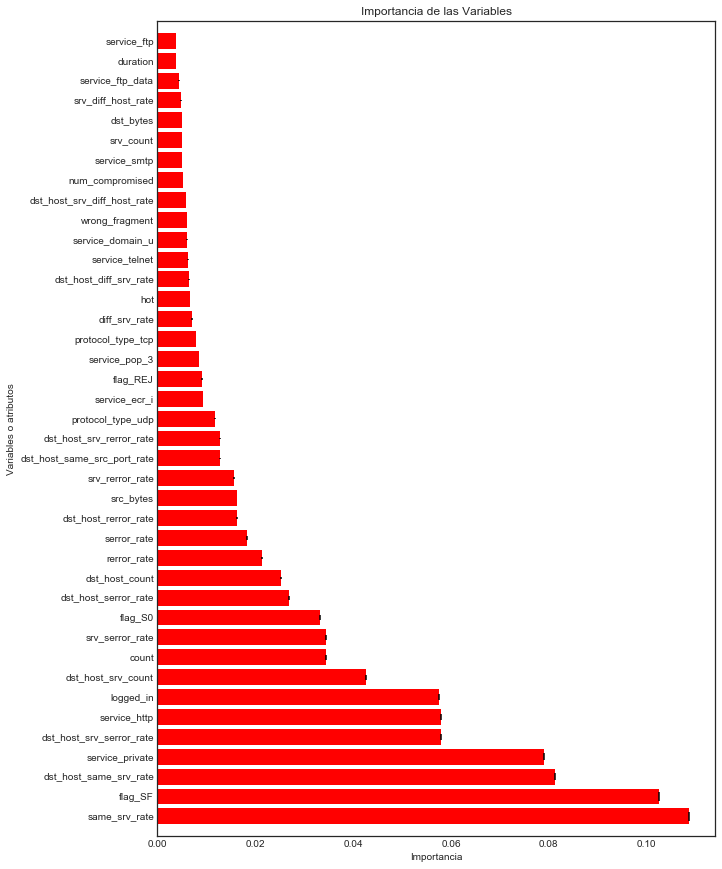

Tiempo total: 26.29s


In [53]:
# Obtenemos las 40 variables mas importantes
num_var = 40
t0 = time()

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Ranking de Variables:")
for f in range(num_var): # X_train.shape[1]
    print("%d. %s - [variable %d] (%f)" % (f + 1, X_train.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(10,15))
plt.title("Importancia de las Variables")
#plt.barh(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.barh(range(num_var), importances[indices[:num_var]], color="r", yerr=std[indices[:num_var]], align="center")

#plt.xticks(range(X_train.shape[1]), indices)
#plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.yticks(range(num_var), X_train.columns[indices[:num_var]])
plt.xlabel("Importancia")
plt.ylabel("Variables o atributos")
#plt.ylim([-1, X_train.shape[1]])
plt.ylim([-1, num_var])
plt.show()

print("Tiempo total: %.2fs" % (time() - t0))

In [54]:
X_train.columns[indices][:40]

Index(['same_srv_rate', 'flag_SF', 'dst_host_same_srv_rate', 'service_private',
       'dst_host_srv_serror_rate', 'service_http', 'logged_in',
       'dst_host_srv_count', 'count', 'srv_serror_rate', 'flag_S0',
       'dst_host_serror_rate', 'dst_host_count', 'rerror_rate', 'serror_rate',
       'dst_host_rerror_rate', 'src_bytes', 'srv_rerror_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_rerror_rate',
       'protocol_type_udp', 'service_ecr_i', 'flag_REJ', 'service_pop_3',
       'protocol_type_tcp', 'diff_srv_rate', 'hot', 'dst_host_diff_srv_rate',
       'service_telnet', 'service_domain_u', 'wrong_fragment',
       'dst_host_srv_diff_host_rate', 'num_compromised', 'service_smtp',
       'srv_count', 'dst_bytes', 'srv_diff_host_rate', 'service_ftp_data',
       'duration', 'service_ftp'],
      dtype='object')

## Separando el conjunto de datos de entrenamiento y de validación
Como hemos visto tenemos 4 conjuntos de datos de los cuales hemos ajustado para los diferentes procesos,

- **X** = Contiene el conjunto de datos de entrenamiento y validación juntos y depurados
- **y_all** = Contiene todos los datos de validación de la variable independiente, todas los tipos de ataques
- **y_4f** = Contiene los datos de validación de la variable independiente, las 4 categorias mas una adicional que nombre "unknown" o desconocida
- **y_bin** = Contiene los datos de validación de la variable independiente en forma binaria (0/1)
- **ataques_10perc** = Contiene los datos de entrenamiento sin duplicados y/o depurados
- **ataques_correg_test_10perc** = Contiene los datos de validación sin duplicados y/o depurados
- **ataques_correg_test_10percAll** = Contiene todos los datos de validación incluyendo duplicados

Ahora lo que haremos es seleccionar un conjunto de datos ajustados a las variables seleccionadas en el paso anterior con el fin de probar con algunos algoritmos. Se utilizarán todos los conjuntos de datos en mención para ver su precisión de incluir o no los datos duplicados y de incluir los datos de validación de la variable independiente de diferentes niveles, desde el más simple (buenas/malas conexiones) hasta identificar el tipo de ataque.

In [55]:
# Podriamos guardar estos conjuntos de datos para luego utilizarlos de manera más rápida o dinámica
# EDA.save_data()

In [56]:
# Seleccion de los predictores
predictores_small = ['srv_count', 'count', 'src_bytes', 'dst_host_same_src_port_rate', 'service_ecr_i']
predictores15var = ['srv_count', 'service_ecr_i', 'dst_host_same_src_port_rate', 'count',
       'protocol_type_tcp', 'same_srv_rate', 'flag_SF',
       'dst_host_same_srv_rate', 'dst_host_srv_count', 'service_private',
       'logged_in', 'flag_S0', 'dst_host_srv_serror_rate', 'dst_host_count',
       'srv_serror_rate']

predictores40var = ['same_srv_rate', 'flag_SF', 'dst_host_same_srv_rate', 'service_private',
       'dst_host_srv_serror_rate', 'service_http', 'logged_in',
       'dst_host_srv_count', 'count', 'srv_serror_rate', 'flag_S0',
       'dst_host_serror_rate', 'dst_host_count', 'rerror_rate', 'serror_rate',
       'dst_host_rerror_rate', 'src_bytes', 'srv_rerror_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_rerror_rate',
       'protocol_type_udp', 'service_ecr_i', 'flag_REJ', 'service_pop_3',
       'protocol_type_tcp', 'diff_srv_rate', 'hot', 'dst_host_diff_srv_rate',
       'service_telnet', 'service_domain_u', 'wrong_fragment',
       'dst_host_srv_diff_host_rate', 'num_compromised', 'service_smtp',
       'srv_count', 'dst_bytes', 'srv_diff_host_rate', 'service_ftp_data',
       'duration', 'service_ftp']

# ataques_10perc_train = pd.concat([ataques_10perc[ataques_10perc.columns[indices][:40]], y_bin], axis=1)

In [57]:
# Definimos X (predictores) e y (respuesta)
# Training 1 - 5 variables y la independiente binaria
Xr5 = ataques_10perc[predictores_small]
yr5 = ataques_10perc.attack_category_bin

# Training 2 - 15 variables y la independiente binaria
Xr15 = ataques_10perc[predictores15var]
yr15 = ataques_10perc.attack_category_bin

# Training 3 - 40 variables y la independiente binaria
Xr40 = ataques_10perc[predictores40var]
yr40 = ataques_10perc.attack_category_bin

# Utilizamos todos los datos para poder comparar al final con la matríz de confusión del ganador del concurso KDDcup
# Test 1 - 5 variables y la independiente binaria
Xt5 = ataques_correg_test_10percAll[predictores_small]
yt5 = ataques_correg_test_10percAll.attack_category_bin

# Test 2 - 15 variables y la independiente binaria
Xt15 = ataques_correg_test_10percAll[predictores15var]
yt15 = ataques_correg_test_10percAll.attack_category_bin

# Test 3 - 40 variables y la independiente binaria
Xt40 = ataques_correg_test_10percAll[predictores40var]
yt40 = ataques_correg_test_10percAll.attack_category_bin

## Selección de algoritmos y métodos

Aquí probaremos varios algoritmos y métodos para luego seleccionar el mejor o los mejores y realizar un emsanble o red neuronal.

### Árbol de desición

In [58]:
t0 = time()
# podriamos separar los datos en entrenamiento y validación, pero como ya los tenemos en archivos o 
# dataframe separados no es necesario realizar de nuevo este paso, sin temor a sobreajustar nuestro modelo
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=35)

# Para 5 variables importantes
#X_train = Xr5
#X_test = Xt5
#y_train = yr5
#y_test = yt5

# Árbol sin poda, como la variable independiente es númerica utilizamos un árbol de regresión
treeclf = DecisionTreeRegressor(random_state=1) # max_depth=15 # DecisionTreeClassifier
treeclf.fit(Xr5,yr5)
# Verificamos la precisión de nuestro modelo, tanto como los datos de entrenamiento y los de validación
print("Precisión Datos Entranamiento: ",treeclf.score(Xr5,yr5))
print("Precisión Datos Validación: ",treeclf.score(Xt5,yt5))

print("Tiempo total: %.2fs" % (time() - t0))

Precisión Datos Entranamiento:  0.990627988208
Precisión Datos Validación:  0.405702622389
Tiempo total: 0.28s


Tiempo total: 0.28s


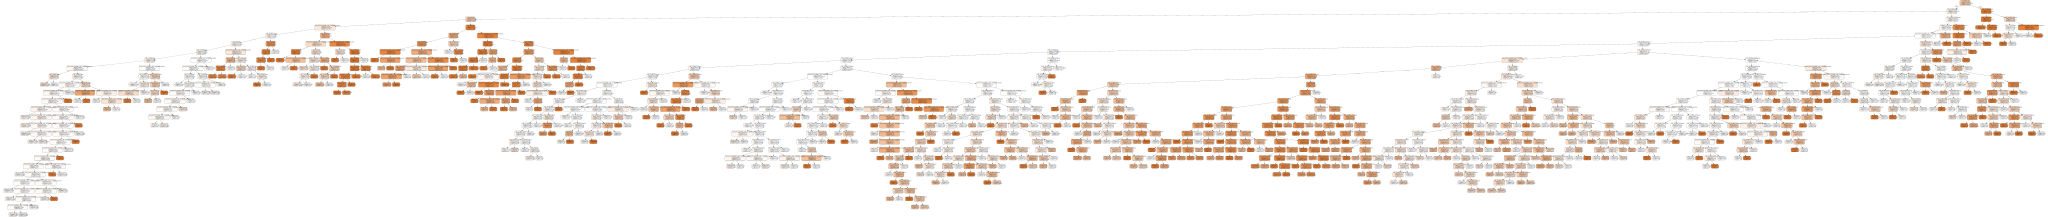

In [59]:
# Podemos gráficar el árbol si deseamos de la sgte forma:
t0 = time()

label_names = yt5.unique().tolist()

# Exportamos los datos del arbol a un archivo
export_graphviz(treeclf,out_file='./data/ataques_5var.dot',  
                impurity=True, filled=True, rounded=True, special_characters=True, 
                feature_names=predictores_small, 
                class_names= label_names )

# Leemos los datos guardados en el paso anterior
with open('./data/ataques_5var.dot') as f:
    dot_graph=f.read()

print("Tiempo total: %.2fs" % (time() - t0))
# Creamos la gráfica a partir de los datos anteriores
graphviz.Source(dot_graph)

**Observamos que la precisión con un solo árbol y utilizando solo la variable independiente binaria no es muy buena**

In [60]:
# Arbol de decisión con 15 variables
t0 = time()
# Ajustamos un árbol de clasificación con 15 niveles máximo (max_depth=15) sobre todos los datos
treeclf = DecisionTreeClassifier(random_state=1)
treeclf.fit(Xr15,yr15)
# Verificamos la precisión de nuestro modelo, tanto como los datos de entrenamiento y los de validación
print("Precisión Datos Entranamiento: ",treeclf.score(Xr15,yr15))
print("Precisión Datos Validación: ",treeclf.score(Xt15,yt15))

print("Tiempo total: %.2fs" % (time() - t0))

Precisión Datos Entranamiento:  0.99669611089
Precisión Datos Validación:  0.921541078163
Tiempo total: 0.53s


In [61]:
# Arbol de decisión con 40 variables
t0 = time()
# Ajustamos un árbol de clasificación con 15 niveles máximo (max_depth=15) sobre todos los datos
treeclf = DecisionTreeClassifier(random_state=1)
treeclf.fit(Xr40,yr40)
# Verificamos la precisión de nuestro modelo, tanto como los datos de entrenamiento y los de validación
print("Precisión Datos Entranamiento: ",treeclf.score(Xr40,yr40))
print("Precisión Datos Validación: ",treeclf.score(Xt40,yt40))

print("Tiempo total: %.2fs" % (time() - t0))

Precisión Datos Entranamiento:  0.999993131208
Precisión Datos Validación:  0.935716605204
Tiempo total: 1.27s


**Observamos que la precisión aumenta un poco más a medida que incrementamos los predictores mas importantes, obtenidos en los pasos anteriores**

In [62]:
# Hacemos prediciones sobre los datos de validación con el modelo de 40 variables que dio mejor precisión
y40_pred_bin = treeclf.predict(Xt40)
# Calcular y desplegar la matríz de confusión
confusion_matrix(yt40, y40_pred_bin)

array([[ 59643,    950],
       [ 19044, 231392]])

Comparamos nuestro primer modelo con los datos del ganador del concurso, mediante una validación cruzada
Como se puede observar en el [documento](http://cseweb.ucsd.edu/~elkan/clresults.html) de los resultados del ganador y del concurso, la matríz de confusión que se presenta es sobre los datos de la variable independiente tomando las 4 categorías de tipos de ataques.

Procedemos entonces a calcularla con estos datos:

In [63]:
# Definimos X e y con las 40 variables y las independiente con 4 categorías
#Xr40 = ataques_10perc[predictores40var]
yr40 = ataques_10perc.attack_category
#Xt40 = ataques_correg_test_10percAll[predictores40var]
yt40 = ataques_correg_test_10percAll.attack_category

# Creamos el Árbol de decisión
t0 = time()
# Ajustamos un árbol de clasificación con 15 niveles máximo (max_depth=15) sobre todos los datos
treeclf = DecisionTreeClassifier(random_state=1)
treeclf.fit(Xr40,yr40)
# Verificamos la precisión de nuestro modelo, tanto como los datos de entrenamiento y los de validación
print("Precisión Datos Entranamiento: ",treeclf.score(Xr40,yr40))
print("Precisión Datos Validación: ",treeclf.score(Xt40,yt40))
print("-"*80)
# Hacemos prediciones sobre los datos de validación
y40_pred_4ctg = treeclf.predict(Xt40)
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(yt40, y40_pred_4ctg)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

Precisión Datos Entranamiento:  0.999993131208
Precisión Datos Validación:  0.919020412888
--------------------------------------------------------------------------------
[[223272     17      9      0      0      0]
 [    73  59506    980      9     25      0]
 [     7      3   2367      0      0      0]
 [     1   5237      9    693     53      0]
 [     0     24      0     11      4      0]
 [  1025  14275   3199    149     81      0]]
Tiempo total: 3.50s


Matríz de Confusión sin Normalización
[[223272     17      9      0      0      0]
 [    73  59506    980      9     25      0]
 [     7      3   2367      0      0      0]
 [     1   5237      9    693     53      0]
 [     0     24      0     11      4      0]
 [  1025  14275   3199    149     81      0]]
Matríz de Confusión Normalizada
[[  1.00e+00   7.61e-05   4.03e-05   0.00e+00   0.00e+00   0.00e+00]
 [  1.20e-03   9.82e-01   1.62e-02   1.49e-04   4.13e-04   0.00e+00]
 [  2.94e-03   1.26e-03   9.96e-01   0.00e+00   0.00e+00   0.00e+00]
 [  1.67e-04   8.74e-01   1.50e-03   1.16e-01   8.84e-03   0.00e+00]
 [  0.00e+00   6.15e-01   0.00e+00   2.82e-01   1.03e-01   0.00e+00]
 [  5.47e-02   7.62e-01   1.71e-01   7.96e-03   4.32e-03   0.00e+00]]


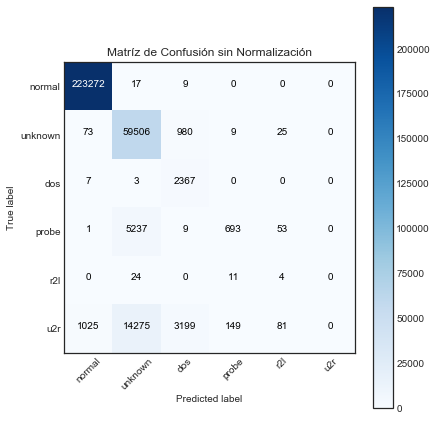

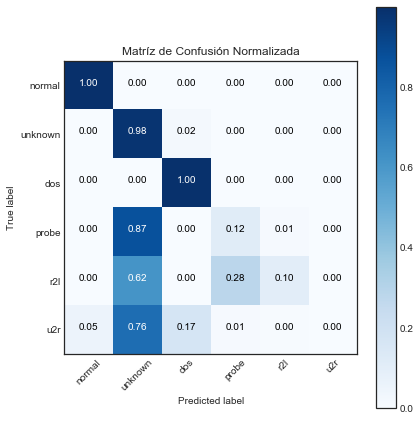

In [64]:
np.set_printoptions(precision=2)

class_names = yt40.unique()

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
EDA.plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Matríz de Confusión sin Normalización')

# Plot normalized confusion matrix
plt.figure(figsize=(6,6))
EDA.plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Matríz de Confusión Normalizada')

plt.show()

In [65]:
# Definimos X e y con las 40 variables y las independiente con todos los tipos de ataque
#Xr40 = ataques_10perc[predictores40var]
yr40 = ataques_10perc.attack_types
#Xt40 = ataques_correg_test_10percAll[predictores40var]
yt40 = ataques_correg_test_10percAll.attack_types

# Creamos el Árbol de decisión
t0 = time()
# Ajustamos un árbol de clasificación con 15 niveles máximo (max_depth=15) sobre todos los datos
treeclf = DecisionTreeClassifier(random_state=1)
treeclf.fit(Xr40,yr40)
# Verificamos la precisión de nuestro modelo, tanto como los datos de entrenamiento y los de validación
print("Precisión Datos Entranamiento: ",treeclf.score(Xr40,yr40))
print("Precisión Datos Validación: ",treeclf.score(Xt40,yt40))
print("-"*80)
# Hacemos prediciones sobre los datos de validación
y40_pred_38ta = treeclf.predict(Xt40)
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(yt40, y40_pred_38ta)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

Precisión Datos Entranamiento:  0.999986262415
Precisión Datos Validación:  0.915519131657
--------------------------------------------------------------------------------
[[   0  467    0 ...,    0    0    0]
 [   0 1098    0 ...,    0    0    0]
 [   0    0    0 ...,    0    0    0]
 ..., 
 [   0    0    0 ...,    0    0    0]
 [   0    0    0 ...,    0    0    0]
 [   0    0    1 ...,    0    0    0]]
Tiempo total: 4.66s


**Observamos que la precisión con todos los tipos de ataques baja un poco para este primer modelo de Árboles de decisión.**

## Random Forest

In [79]:
# Al parecer esto toma mucho tiempo encontrar los mejores parametros.
# Como ya se habia ejecutado en otro cuaderno de notas, tomaremos los parametros de ahí
t0 = time()

# Definimos X e y con las 40 variables y las independiente con 4 categorías
#Xr40 = ataques_10perc[predictores40var]
yr40 = ataques_10perc.attack_category
#Xt40 = ataques_correg_test_10percAll[predictores40var]
yt40 = ataques_correg_test_10percAll.attack_category

rfclf = RandomForestClassifier(n_jobs=-1) # utilizamos todos los procesadores y el GPU

# Escogemos algunas combinaciónes de parametros para escoger la mejor al final
parameters = {'n_estimators': [5, 10], 
               'max_features': ['log2', 'sqrt','auto'], 
               'criterion': ['entropy', 'gini'],
               'max_depth': [5, 10, 15], 
               'min_samples_split': [3, 5],
               'min_samples_leaf': [1,5,8]
              }

# Tipo de puntaje usado para comparar la mejor combinación de parametros 
acc_scorer = make_scorer(accuracy_score)

# Ejecutamos el metodo "grid search" o de busqueda de los mejores parametros para el clasificador escogido
grid_obj = GridSearchCV(rfclf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(Xr40, yr40)

# Ajustamos el clasificador con la mejor combinación de parametros
rfclf = grid_obj.best_estimator_

# Ajustamos el mejor algortimo para los datos de las 40 variables 
rfclf.fit(Xr40, yr40)
print(rfclf)

predictions = rfclf.predict(Xt40)
print("Precisión usando Random Forest: ", accuracy_score(yt40, predictions))

# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(yt40, predictions)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Precisión usando Random Forest:  0.388233894589
[[ 58502 164788      8      0      0      0]
 [    70  60360    163      0      0      0]
 [    10    477   1890      0      0      0]
 [     0   5993      0      0      0      0]
 [     0     39      0      0      0      0]
 [   217  17670    842      0      0      0]]
Tiempo total: 562.83s


In [67]:
t0 = time()
# Definimos X e y con las 40 variables y las independiente con 4 categorías
# Xr40 = ataques_10perc[predictores40var]
yr40 = ataques_10perc.attack_category
# Xt40 = ataques_correg_test_10percAll[predictores40var]
yt40 = ataques_correg_test_10percAll.attack_category


rfclf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0, warm_start=False)

# # Ajustamos el mejor algortimo para los datos de las 40 variables 
rfclf.fit(Xr40, yr40)
predictions = rfclf.predict(Xt40)
print("Precisión usando Random Forest: ", accuracy_score(yt40, predictions))

# # Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(yt40, predictions)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

Precisión usando Random Forest:  0.921563584103
[[223274     10     14      0      0      0]
 [    70  60278    238      4      3      0]
 [     4      1   2372      0      0      0]
 [     0   5282      2    707      2      0]
 [     0     32      0      5      2      0]
 [   893  16888    940      4      4      0]]
Tiempo total: 3.10s


### Random Forest con Boostrap

In [68]:
t0 = time()
# Definimos X e y con las 40 variables y las independiente con 4 categorías
# Xr40 = ataques_10perc[predictores40var]
yr40 = ataques_10perc.attack_category
# Xt40 = ataques_correg_test_10percAll[predictores40var]
yt40 = ataques_correg_test_10percAll.attack_category

# Modificamos la variables boostrap, criterion y el número de estimadores
rfclf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0, warm_start=False)

# Ajustamos el mejor algortimo para los datos de las 40 variables 
rfclf.fit(Xr40, yr40)
predictions = rfclf.predict(Xt40)
print("Precisión usando Random Forest: ", accuracy_score(yt40, predictions))

# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(yt40, predictions)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

Precisión usando Random Forest:  0.922303064988
[[223266     16     16      0      0      0]
 [    69  60298    223      2      1      0]
 [     3      6   2368      0      0      0]
 [     0   5064      0    928      1      0]
 [     0     34      0      2      3      0]
 [   540  17291    892      3      3      0]]
Tiempo total: 6.25s


### Extra Trees Classification

In [69]:
# Extra Trees Classification
t0 = time()
seed = 7
num_trees = 100
max_features = 7
kfold = KFold(n_splits=10, random_state=seed)
model = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
results = cross_val_score(model, Xr40, yr40, cv=kfold)
print(results.mean())
model.fit(Xr40, yr40)

precision = model.score(Xt40, yt40)
print("Puntaje de Validación Extra Trees: ",precision)
# Predicciones
y_pred_class = model.predict(Xt40)
# Matríz de correlación
cnf_matrix = confusion_matrix(yt40, y_pred_class)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

0.991840055501
Puntaje de Validación Extra Trees:  0.920402920628
[[222772      7    519      0      0      0]
 [    72  60252    261      4      4      0]
 [     3     10   2364      0      0      0]
 [     0   5104      2    880      7      0]
 [     0     30      0      5      4      0]
 [   647  17028   1038      3     13      0]]
Tiempo total: 82.72s


## Validación Cruzada con KFold

In [70]:
t0 = time()
run_kfold(rfclf, Xr40, yr40)
print("Tiempo total: %.2fs" % (time() - t0))

Grupo 1 precisión: 0.9998626279277423
Grupo 2 precisión: 0.9943677450374339
Grupo 3 precisión: 0.9937495707122742
Grupo 4 precisión: 0.9987636513496806
Grupo 5 precisión: 0.9995878837832268
Grupo 6 precisión: 0.9587196922865582
Grupo 7 precisión: 0.9980766588817145
Grupo 8 precisión: 0.997870586619041
Grupo 9 precisión: 0.9990383294408572
Grupo 10 precisión: 0.9992444017035307
Precisión promedio: 0.9939281147742058
Tiempo total: 42.63s


### Árboles de Decisión con Bagging

In [71]:
t0 = time()

clf_bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf_bagging.fit(Xr40, yr40)
y_pred = clf_bagging.predict(Xt40)
#metrics.f1_score(y_pred, y_test) 
print("Precisión usando Árboles con Bagging: ",metrics.accuracy_score(y_pred, yt40))

# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(yt40, y_pred)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Precisión usando Árboles con Bagging:  0.91930012957
[[223275     16      7      0      0      0]
 [    73  59533    978      5      4      0]
 [     8      1   2368      0      0      0]
 [     0   5235      9    746      3      0]
 [     0     28      0      4      7      0]
 [   825  14463   3427      4     10      0]]
Tiempo total: 54.68s


### KNN con Bagging

In [78]:
# Bagging with KNN - toma algo de tiempo
t0 = time()

knnclf_bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5, n_estimators=10, 
                                bootstrap=True, random_state=42, n_jobs=-1, oob_score=False )

knnclf_bagging.fit(Xr40, yr40)
y_pred = knnclf_bagging.predict(Xt40)
print("Score Validación KNN con Bagging: ", metrics.accuracy_score(y_pred, yt40))

# Hacer las predicciones
y_pred_class = knnclf_bagging.predict(Xt40)
# Matríz de correlación
cnf_matrix = confusion_matrix(yt40, y_pred_class)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Score Validación KNN con Bagging:  0.918798568622
[[223240     53      5      0      0      0]
 [   149  60336    107      1      0      0]
 [   275     16   2086      0      0      0]
 [     0   5872     10    111      0      0]
 [     0     39      0      0      0      0]
 [   176  17851    702      0      0      0]]
Tiempo total: 989.03s


### Gradient Boosting

In [72]:
# GBRT
gbclf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0)
gbclf.fit(Xr40, yr40)

t0 = time()
precision = gbclf.score(Xt40, yt40)
print("Score Validación GBRT: ",precision)
# Predicciones
y_pred_class = gbclf.predict(Xt40)
# Matríz de correlación
cnf_matrix = confusion_matrix(yt40, y_pred_class)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Score Validación GBRT:  0.911136903633
[[222569     48    375    246     60      0]
 [   588  59349    108    474     74      0]
 [   362   1602    173     20    220      0]
 [     4   4558     94   1292     45      0]
 [     1     24      0      7      7      0]
 [   539  17859    137     66    128      0]]
Tiempo total: 8.30s


### AdaBoost

In [73]:
# Utilizando AdaBoost
t0 = time()

#bdt_real = AdaBoostClassifier( DecisionTreeClassifier(max_depth=15), n_estimators=500, learning_rate=1)
#bdt_discrete = AdaBoostClassifier( DecisionTreeClassifier(max_depth=15), n_estimators=500, learning_rate=1.5,
#    algorithm="SAMME")

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15), n_estimators=100) # algorithm="SAMME", algorithm="SAMME.R", learning_rate=1.0

bdt.fit(Xr40, yr40)
scores = cross_val_score(bdt, Xr40, yr40)
print(scores.mean())

print("Tiempo total: %.2fs" % (time() - t0))

y_pred = bdt.predict(Xt40)
print(metrics.accuracy_score(y_pred, yt40))

t0 = time()
precision = bdt.score(Xt40, yt40)
print("Score Validación AdaBoost: ",precision)

# Predicciones
y_pred_class = bdt.predict(Xt40)
# Matríz de correlación
cnf_matrix = confusion_matrix(yt40, y_pred_class)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

0.925780332751
Tiempo total: 230.82s
0.920968784261
Score Validación AdaBoost:  0.920968784261
[[223268      9     21      0      0      0]
 [    71  60292    225      2      3      0]
 [     3      1   2373      0      0      0]
 [     0   5478      0    511      4      0]
 [     0     33      0      2      4      0]
 [   732  17227    762      4      4      0]]
Tiempo total: 17.96s


### Staking o Voting

In [74]:
# from sklearn.svm import SVC

# Training classifiers
t0 = time()
clf1 = DecisionTreeClassifier(max_depth=15)
clf2 = KNeighborsClassifier(n_neighbors=5)
#clf3 = SVC(kernel='rbf', probability=True)
#eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2,1,2])
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2)], voting='soft', weights=[1,1])

clf1 = clf1.fit(Xr40, yr40)
clf2 = clf2.fit(Xr40, yr40)
#clf3 = clf3.fit(Xr40, yr40) # Esto toma demasiado tiempo

eclf = eclf.fit(Xr40, yr40)
print("Tiempo total: %.2fs" % (time() - t0))

t0 = time()

# Validamos los datos de prueba
precision = eclf.score(Xt40, yt40)
print("Score Validación Voting: ",precision)
# make predictions for testing set
y_pred_class = eclf.predict(Xt40)
# Matríz de correlación
cnf_matrix = confusion_matrix(yt40, y_pred_class)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Tiempo total: 36.53s
Score Validación Voting:  0.920377199554
[[223265     19     14      0      0      0]
 [   165  60283    142      3      0      0]
 [   150      4   2223      0      0      0]
 [     0   5196    302    489      6      0]
 [     0     32      0      3      4      0]
 [  1027  16926    775      1      0      0]]
Tiempo total: 50.75s


Como se aprecia, no se utilizaron métodos rigurozamente escogidos, sino solo dos para mostrar la bonda del clasificador. Se debe realizar un clasificador con los mejores vistos arriba y mirar que sucede con la presición del modelo. 

## Resumen de los métodos utilizados

| MODELO                                                 						|	Validación | 
| --- | --- |
| 1. Árbol de desición (clasif. binario)                 						|	0.405702622389 |
| 2. Árbol de desición (4 categ.)                        						|	0.921541078163 |
| 3. Árbol de desición (40 var 4 ctg)                    						|	0.935716605204 |
| 4. Árbol de desición (40 var 38 tipos ataques)         						|	0.915519131657 |
| 5. Random Forest (GridSearchCV, 38 attacks ) *         						|	0.388233894589 |
| 5. Random Forest (GridSearchCV, 4 ctg)                                        |	0.921586090043 |
| 6. Random Forest (Sin Bootstrap)                                              |	0.921563584103 |
| 7. Random Forest (Con Boostrap)                                               |	0.922303064988 |
| 8. Extra Trees                                                                |	0.920402920628 |
| 9. Random Forest con KFold                                                    |	0.993928114775 |
| 10. Árboles de Decisión con Bagging                                           |	0.919300129570 |
| 11. KNN con Bagging                                                           |	0.918798568622 |
| 12. Gradient Boosting Regression Trees                                        |	0.911136903633 |                  
| 13. Árboles de Decisión con AdaBoost                                          |	0.920968784261 |
| 14. Voting (DT, KNN)                                                          |	0.920377199554 |


In [86]:
#import plotly
#from plotly.graph_objs import Bar, Scatter, Layout, Figure
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#plotly.offline.init_notebook_mode(connected=True)

Xdata = ['DT-Bin', 'DT-4ctg', 'DT-var40', 'DT-38attacks', 'RF-GS-38attacks', 'RF-GS-4ctg', 'RF-noBoostrap', 
         'RF-Bagging', 'ExtraTrees', 'RF-Kfold', 'DT-Bagging', 'KNN-Bagging', 'GBRT', 'DT-AdaBoost', 'Voting-DT-KNN']
Ydata = [0.405702622389, 0.921541078163,0.935716605204,0.915519131657,0.388233894589,0.921586090043,0.921563584103,
         0.922303064988,0.920402920628,0.993928114775,0.919300129570,0.918798568622,0.911136903633,0.920968784261,
         0.920377199554]
Ydata = np.dot(Ydata, 100)

clasificadores = Bar(x=Xdata, y=Ydata, name='Modelo', marker=dict(color='#26aff8 ') )

data = [clasificadores]
layout = Layout(title="Precisión de Modelos Evaluados", xaxis=dict(title='Clasificador'), 
                yaxis=dict(title='Precisión (porcentaje)'))
fig = Figure(data=data, layout=layout)

iplot(fig)

## Comparación de resultados con el ganador del KDDCup

Ya tenemos unos resultados que nos pueden orientar en el mejor clasificador a utilizar para comparar con el método del ganador del KDDCup del 99. Se debe tener en cuenta que solo se han utilizado con algunos parametros basicos y con el juego de datos del 10% que ofrecen.

Los métodos con mayor presición fueron **Árboles de Decisión con Bagging (93.57%)** y **Random Forest con KFold (%99.39)**; Aunque estos fueron los que obtuvieron mayores puntajes, es necesario evaluarlos de nuevo, por que el DT podría estar sobreajustado y el Kfold no se ha implementado sobre los datos de validación al parecer.

Por el momento, aquí mostramos los resultados de Random Forest con **Boosting and Bagging (92.23%)**:

|predicted | dos |  normal | probe  |  r2l  |   u2r  |  unknown  |  correct |
|--- | --- | --- | --- | --- | --- | --- | --- |
|**dos**| **223266**  |   16  |   16   |   0   |   0  |  0 | 99.99 %  |
|**normal**|69  | **60298**  |  223  |    2   |   1   |   0 | 99.51 % |
|**probe**|3   |   6  |  **2368**   |   0    |   0   |   0 | 99.62 % |
|**r2l**|0   | 5064 |     0   | **928**    |  1    |  0 | 15.48 % |
|**u2r**|0   |   34 |     0   |   2    |  **3**    |  0 | 7.69 % |
|**unknown**|540 | 17291 |   892  |    3   |  3  |   **0** | 0%  |


**Es necesario hacer el ejercicio con todos los datos ofrecidos y mirar la precisión de nuevo, esto puede realizarse con 2 a 3 metodos de los anterior descritos.**


In [151]:
#yt40.sort_values().unique()
#yt40.value_counts()

In [150]:
#labels = ["dos", "normal", "unknown", "r2l", "probe", "u2r"]
#reales = [223298, 60593, 18729, 5993, 2377, 39]
labels = ["dos", "normal", "r2l", "probe", "u2r"]
reales = [223298, 60593, 5993, 2377, 39]
winner = [223226, 60262, 3471, 1360, 30]
solucion1 = [223266, 60298, 2368, 928, 3]


trace1 = Bar( x=labels, y=reales, name='Reales' )
trace2 = Bar( x=labels, y=winner, name='Ganador KDDCup')
trace3 = Bar( x=labels, y=solucion1, name='Mi Solución')

data = [trace1, trace2, trace3]
layout = Layout( barmode='group')

layout = Layout(barmode='group', title="Comparación de Observaciones correctas e incorrectas", xaxis=dict(title='Categoría de Tipos de Ataque'), 
                yaxis=dict(title='Cantidad de observaciones (miles)'))
fig = Figure(data=data, layout=layout)

iplot(fig)

#### PERFORMANCE OF THE WINNING ENTRY

The winning entry achieved an average cost of 0.2331 per test example and obtained the following confusion matrix:

|predicted | 0 |  1 | 2  |  3   |   4   |  correct |
|---    | --- | --- | --- | --- | --- | --- |
|0         |   60262 |  243  |  78   |   4 |     6   |    99.5% |
|1         |     511 |  3471 |   184 |   0 |     0   |    83.3% |
|2         |    5299 |  1328 | 223226|   0 |     0   |    97.1% |
|3         |     168 |    20 |     0 |  30 |    10   |    13.2% |
|4         |   14527 |   294 |     0 |   8 |  1360   |     8.4% |
| --- | --- | --- | --- | --- | --- | --- |
| correct  | 74.6% | 64.8% | 99.9% | 71.4% | 98.8% | --- |

In the table above the five attack categories are numbered as follows:

|código| tipo de ataque |
|---| --- |
|0 |	normal                  |
|1 |	probe                   |
|2 |	denial of service (DOS) |
|3 |	user-to-root (U2R)      |
|4 |	remote-to-local (R2L)   |

We briefly describe [our approach](https://www.researchgate.net/publication/220520055_Winning_the_KDD99_Classification_Cup_Bagged_Boosting) for the KDD99 Classification Cup. The solution is essentially a mixture of bagging and boosting. Additionally, asymmetric error costs are taken into account by minimizing the so-called conditional risk. Furthermore, the standard sampling with replacement methodology of bagging was modified to put a specific focus on the smaller but expensive-if-predicted-wrongly classes.